In [2]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from scipy.stats import wasserstein_distance,median_abs_deviation
from scipy import stats
from tqdm.auto import tqdm
sys.path.append(os.path.abspath("../../src"))  # Adds 'src' to the module search path

In [3]:
from plot import plot_dataset_distributions,horizontal_boxplot,create_MAD_comparison_violinplot,plot_kde_grouped,plot_bar_vertical
from read_data import apply_index_file
tqdm.pandas()

In [4]:
np.random.seed(42)
DATASET = "../../raw_data/dataset_preprocessed.parquet"

# Distribution analysis

In [5]:
df = pd.read_parquet(DATASET,engine="pyarrow")

In [6]:
df.head()

,modified_sequence,label,filename,dataset,task
0,AAAAAAAAAAAAAAAAG,77.383600,Bibo_20130621_CHS_IEF_3-10linear_24slices_08.m...,MSV000080274,iRT
1,AAAAAAAAAAAAAAAAG,93.708580,Bibo_20130621_CHS_IEF_3-10linear_24slices_15.m...,MSV000080274,iRT
2,AAAAAAAAAAAAAAAAG,89.782983,Bibo_20130621_CHS_IEF_3-10linear_24slices_16.m...,MSV000080274,iRT
3,AAAAAAAAAAAAAAAAG,85.309409,Bibo_20130621_CHS_IEF_3-10linear_24slices_18.m...,MSV000080274,iRT
4,AAAAAAAAAAAAAAAAG,99.475931,Bibo_20130621_CHS_IEF_3-10linear_24slices_20.m...,MSV000080274,iRT


In [7]:
print(f"length of the dataset is {len(df)}")

length of the dataset is 27236456


In [8]:
df[['filename','dataset','modified_sequence']].nunique()

filename               2892
dataset                  62
modified_sequence    964395
dtype: int64

## Dataset distributions

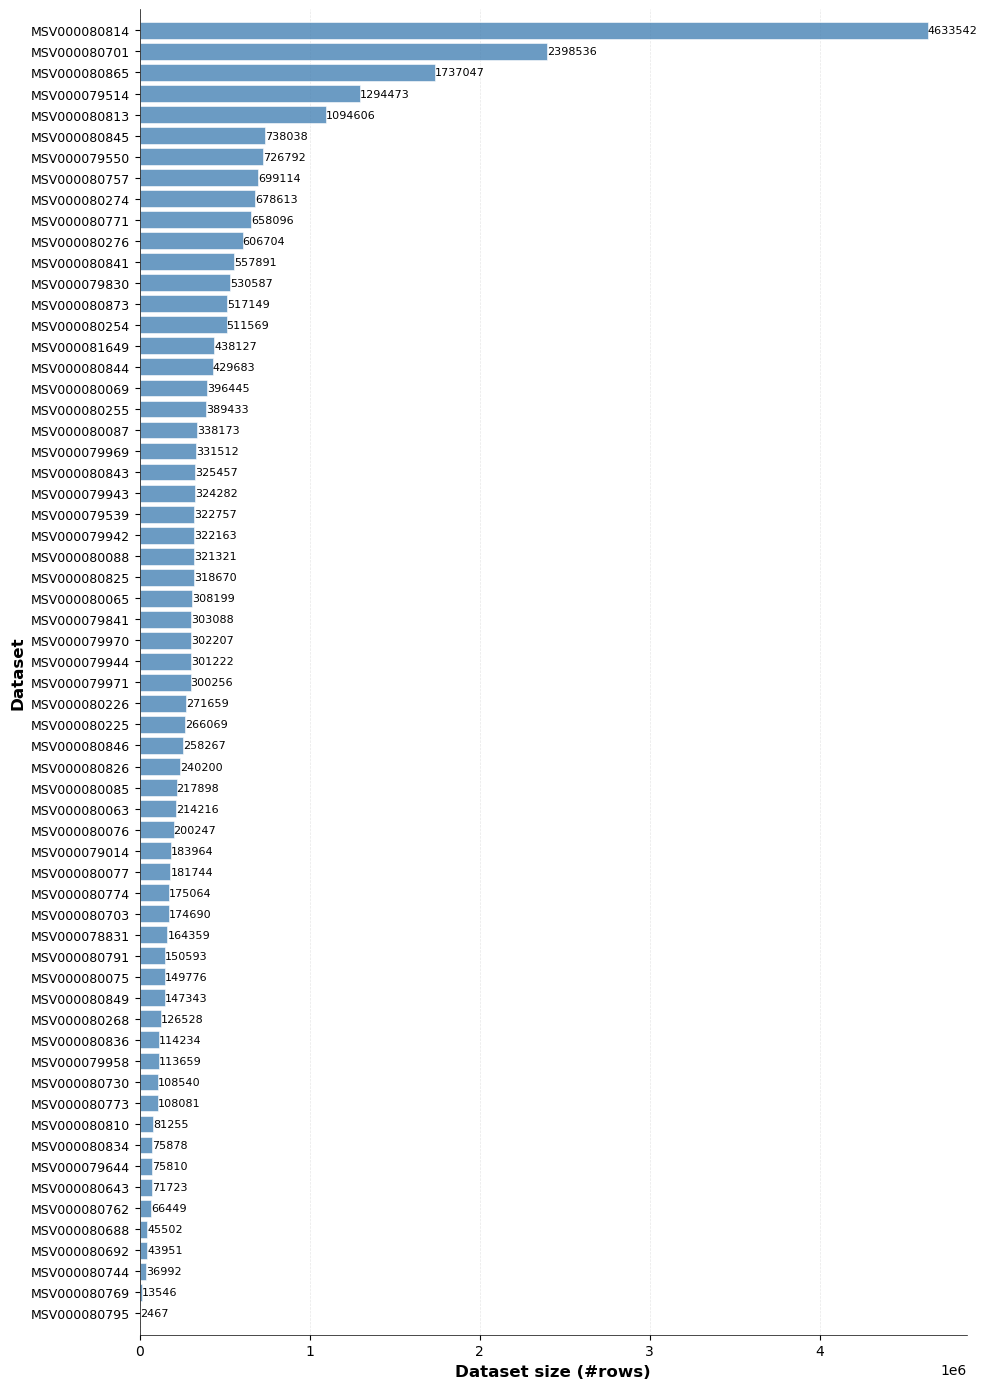

In [9]:
sequences_dataset = df.groupby('dataset')['modified_sequence'].count()
plot_dataset_distributions(sequences_dataset,'Dataset size (#rows)','Dataset')

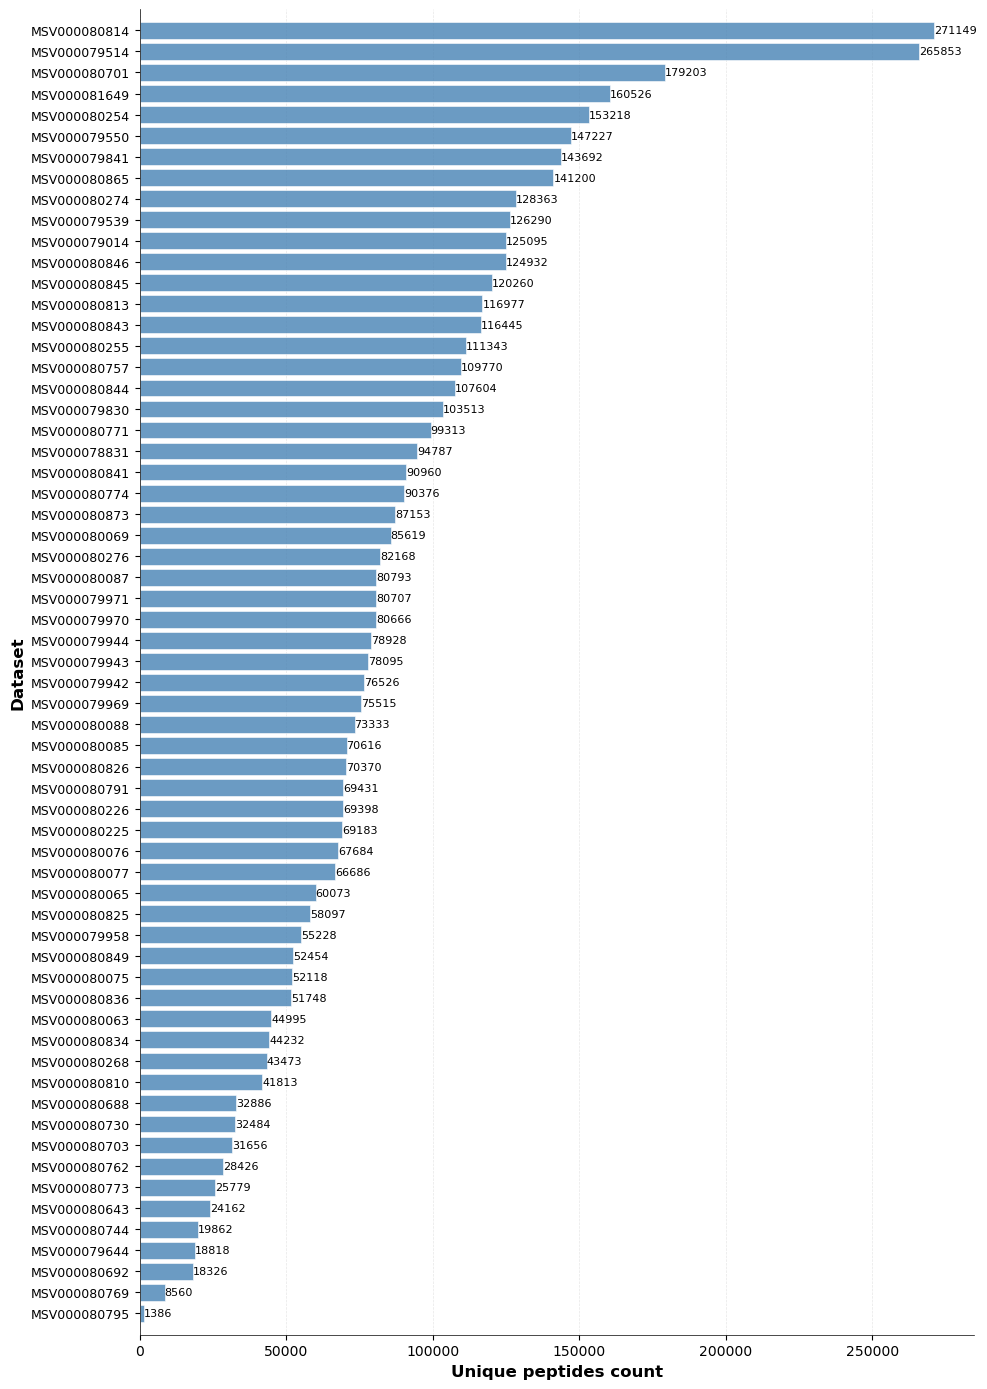

In [10]:
unique_sequences_dataset = df.groupby('dataset')['modified_sequence'].nunique()
plot_dataset_distributions(unique_sequences_dataset,'Unique peptides count','Dataset')

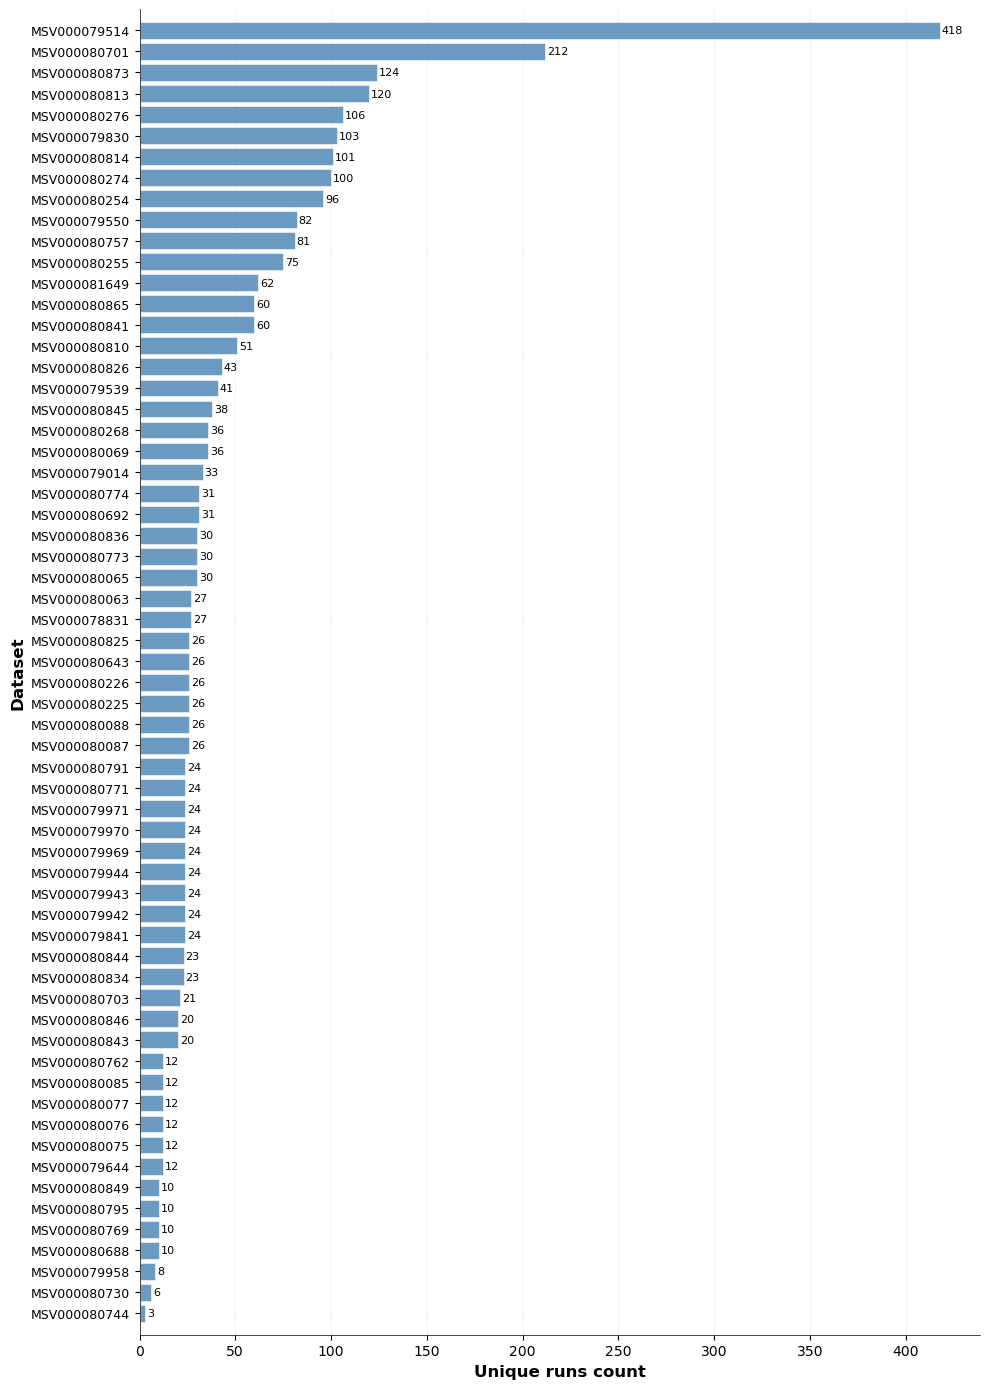

In [11]:
unique_filenames_dataset = df.groupby('dataset')['filename'].nunique()
plot_dataset_distributions(unique_filenames_dataset,'Unique runs count','Dataset')

## Peptide distributions

In [12]:
df = pd.read_parquet(DATASET,engine="pyarrow")

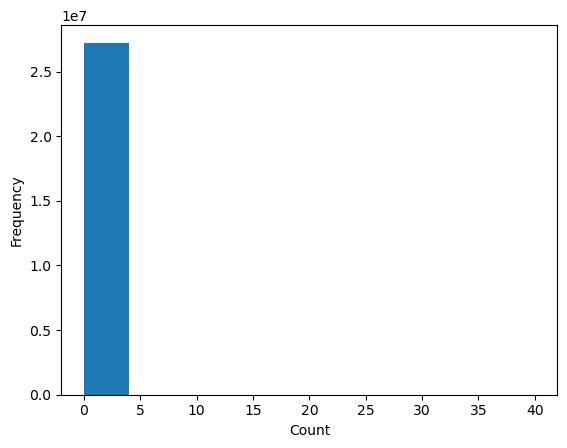

In [13]:
overlap_in_file = df.groupby(['modified_sequence','filename'])['filename'].count()
overlap_in_file.plot.hist(range=(0, 40))
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

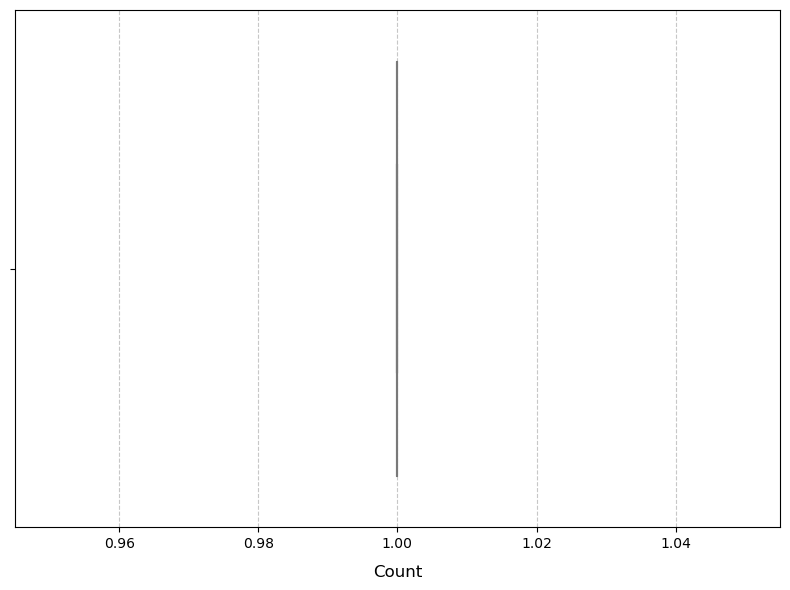

In [14]:
horizontal_boxplot(overlap_in_file,"Count")

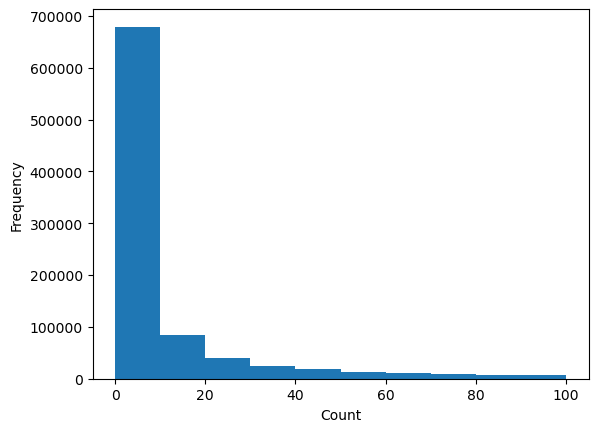

In [15]:
overlap_across_file = df.groupby('modified_sequence')['filename'].nunique()
overlap_across_file.plot.hist(range=(0, 100))
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

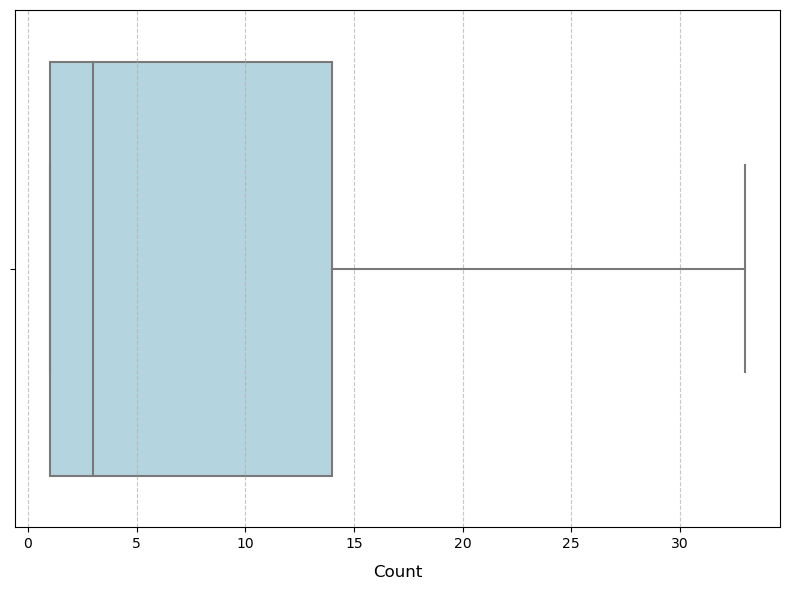

In [16]:
horizontal_boxplot(overlap_across_file,"Count")

# Retention time analysis

In [17]:
def median_absolute_deviation(series, threshold=None):
    if threshold is not None and len(series) < threshold:
        return None
    return stats.median_abs_deviation(series.values)

## MAD comparison

In [10]:
df = pd.read_parquet(DATASET,engine="pyarrow")

In [19]:
mad_msrun = df.groupby(['modified_sequence', 'filename'])['label'].progress_apply(
    lambda x: median_absolute_deviation(x, 2)
).dropna()

  0%|          | 0/27236456 [00:00<?, ?it/s]

In [11]:
mad_dataset = df.groupby(['modified_sequence', 'dataset'])['label'].progress_apply(
    lambda x: median_absolute_deviation(x, 2)
).dropna()

  0%|          | 0/5237543 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
mad_all = df.groupby(['modified_sequence'])['label'].progress_apply(
    lambda x: median_absolute_deviation(x, 2)
).dropna()

  0%|          | 0/964395 [00:00<?, ?it/s]

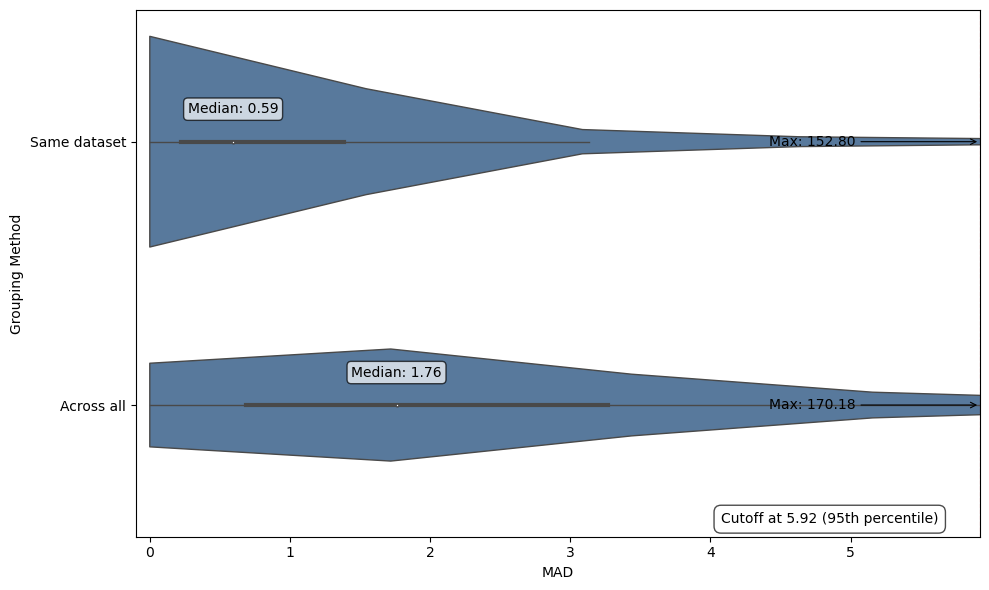

In [22]:
create_MAD_comparison_violinplot([mad_msrun,mad_dataset,mad_all],["Same MS run","Same dataset","Across all"],title="")

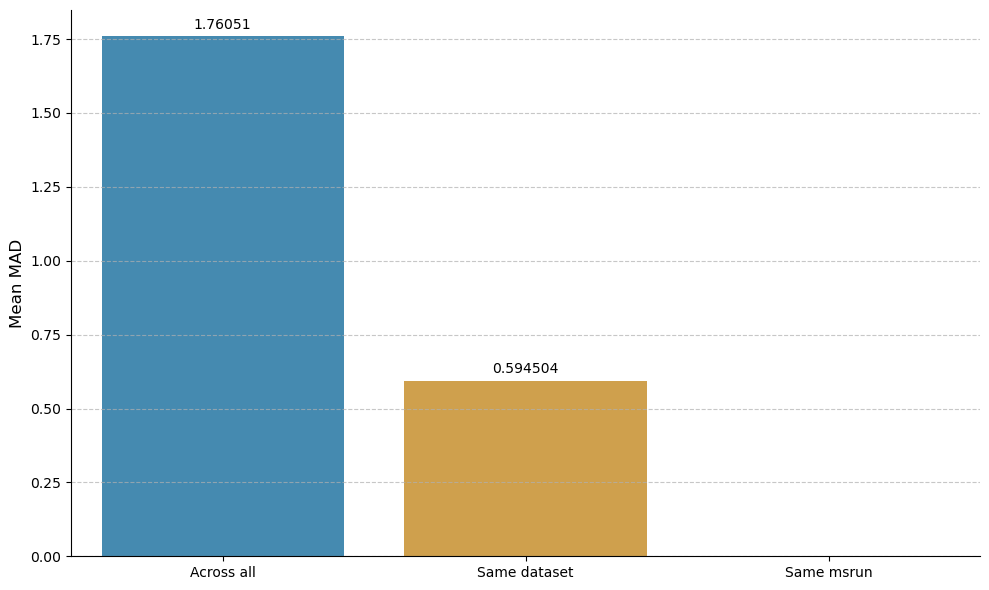

In [23]:
comparison = pd.Series(
    [mad_msrun.median(),mad_dataset.median(),mad_all.median()],
    index=["Same msrun","Same dataset","Across all"]
)
# Call the plotting function with the Series
plot_bar_vertical(
    data_series=comparison,
    title="",
    xlabel="",
    ylabel="Mean MAD",
    figsize=(10, 6)
)

## Find good validation and test set

In [64]:
df = pd.read_parquet(DATASET,engine="pyarrow")

In [74]:
# Get the size of each dataset
dataset_sizes = df.groupby('dataset').size()
large_datasets = dataset_sizes[dataset_sizes >= 400000].index

# Filter to only include rows from datasets with >= 50,000 entries
df_filtered = df[df['dataset'].isin(large_datasets)]

# Now apply your groupby operation on the filtered data
grouped = df_filtered.groupby(['modified_sequence', 'dataset'])['label'].progress_apply(
    lambda x: median_absolute_deviation(x,2)
).dropna()

plot_data = grouped.reset_index()
plot_data.columns = ['modified_sequence', 'dataset', 'mad_value']

  0%|          | 0/2364457 [00:00<?, ?it/s]

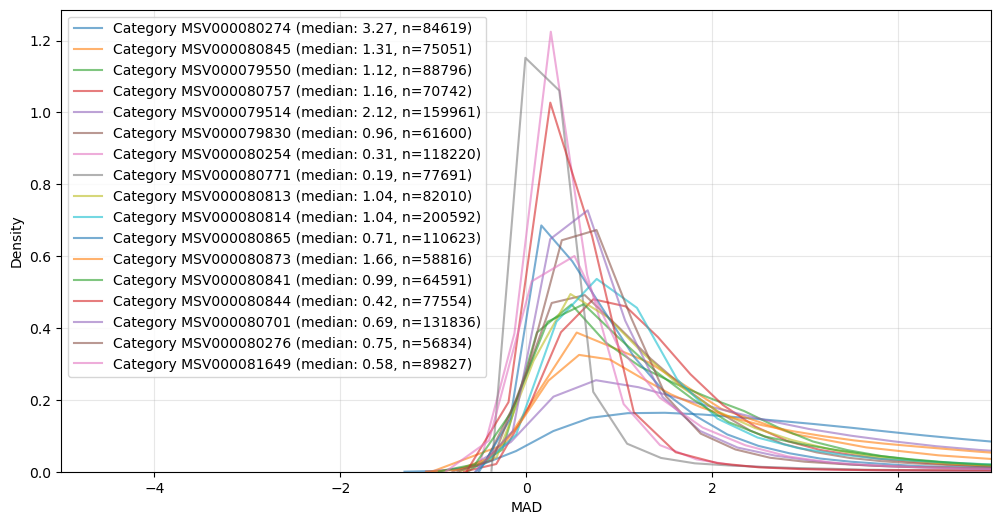

In [78]:
# KDE plot for x by category with median and dataset size in legend
plt.figure(figsize=(12, 6))
# Plot x distribution for each category
for category in plot_data['dataset'].unique():
    subset = plot_data[plot_data['dataset'] == category]
    median_val = subset['mad_value'].median()
    dataset_size = len(subset)
    
    sns.kdeplot(x=subset['mad_value'], 
                label=f'Category {category} (median: {median_val:.2f}, n={dataset_size})', 
                fill=False, alpha=0.6)
plt.xlabel('MAD')
plt.ylabel('Density')
plt.legend()
plt.xlim(-5, 5)
plt.grid(True, alpha=0.3)
plt.show()

In [67]:
df1 = df[df["dataset"]=="MSV000080813"]

In [68]:
df2 = df[df["dataset"]=="MSV000080845"]

In [71]:
m1=df1.groupby('modified_sequence')['label'].apply(lambda x: median_absolute_deviation(x,2)).dropna()
m2=df2.groupby('modified_sequence')['label'].apply(lambda x: median_absolute_deviation(x,2)).dropna()

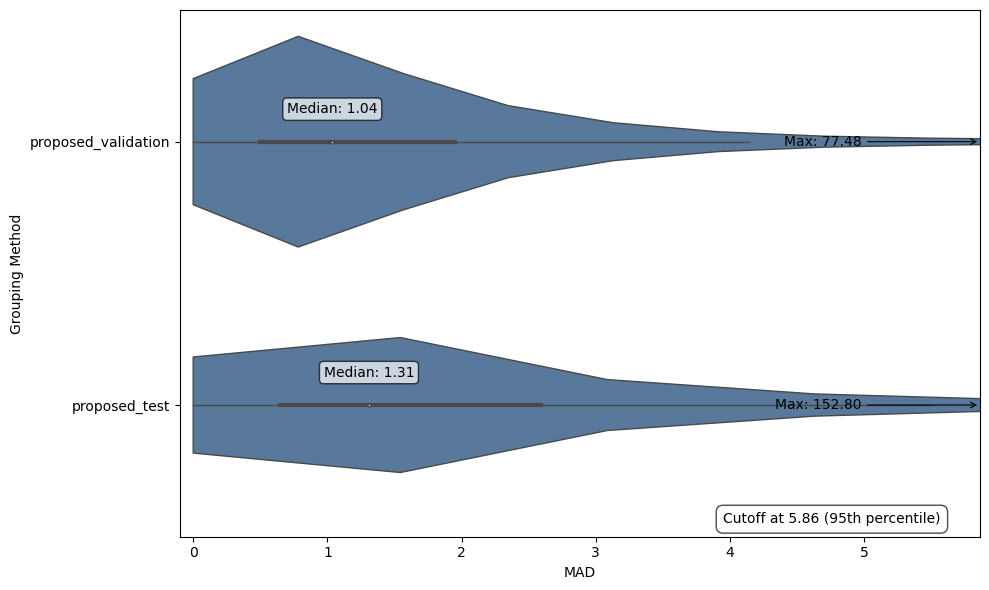

In [73]:
create_MAD_comparison_violinplot([m1,m2],["proposed_validation","proposed_test"],title="")

# Analysis split

In [5]:
DATA = "../../data/"
DATASET = "../../data/dataset.parquet"
VAL = "../../data/val.csv"
TEST = "../../data/test.csv"
TRAIN = "../../data/train.csv"

In [6]:
df = pd.read_parquet(DATASET,engine="pyarrow")
val_df = apply_index_file(df,VAL)
test_df = apply_index_file(df,TEST)
train_df = apply_index_file(df,TRAIN)

In [10]:
print(f"length of train is {len(train_df)}")
print(f"length of val is {len(val_df)}")
print(f"length of test is {len(test_df)}")
print(f"sum is  {len(test_df)+len(val_df)+len(train_df)}")

length of train is 7786779
length of val is 249607
length of test is 247344
sum is  8283730


## validation split

In [36]:
df = pd.read_parquet(DATASET,engine="pyarrow")
val_df = apply_index_file(df,VAL)
test_df = apply_index_file(df,TEST)

In [41]:
mad_all_val=val_df.groupby('modified_sequence')['label'].apply(lambda x: median_absolute_deviation(x,2)).dropna()
mad_all_test=test_df.groupby('modified_sequence')['label'].apply(lambda x: median_absolute_deviation(x,2)).dropna()

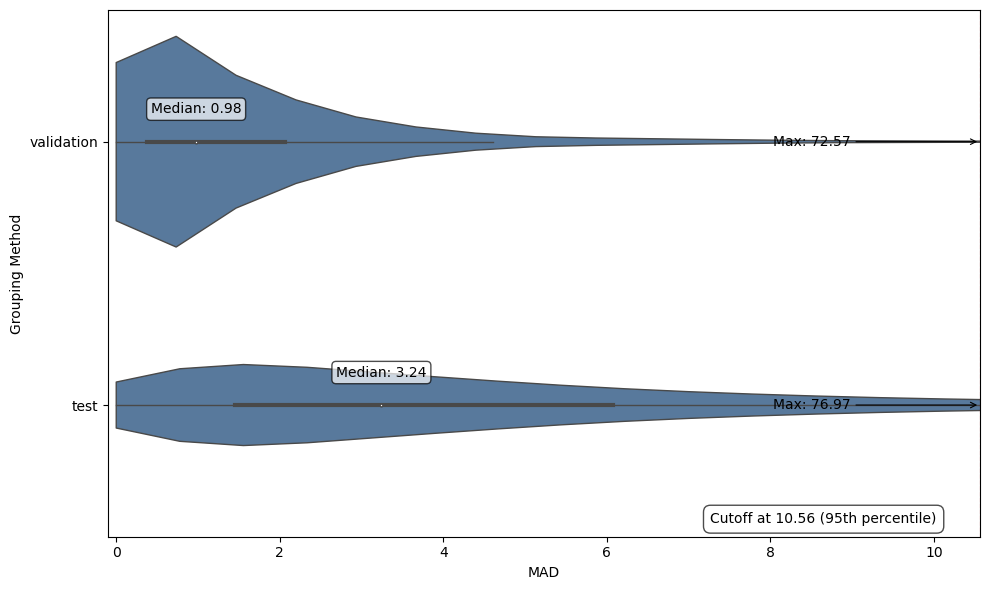

In [42]:
create_MAD_comparison_violinplot([mad_all_val,mad_all_test],["validation","test"],title="")

## Testing

In [5]:
df = pd.read_parquet("../../data/dataset.parquet")